In [1]:
import os
import sys
sys.path.append('/data/idvor/python_scripts/')
import baseline, analysis, datasets
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import itertools
import json
import seaborn as sns
from sklearn.manifold import TSNE, MDS
import glob
import math

2022-11-09 21:37:48.212570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
modelPath = '../outputs/masterOutput/models/w0s0.pb'
print('Loading model')
model = tf.keras.models.load_model(modelPath)
model.summary()

Loading model


2022-11-09 21:39:46.516663: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-09 21:39:46.550281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 21:39:46.550861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 208.91GiB/s
2022-11-09 21:39:46.550888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-09 21:39:46.553598: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-09 21:39:46.553655: I tensorflow/stream_executor/plat

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 192)         3

In [3]:
def bootstrapCI(x, nSamples=1000):
    means = np.array(
        [np.nanmean(np.random.choice(x, len(x))) for i in range(nSamples)]
    )
    means = np.sort(means)
    return means[int(nSamples * 0.025)], means[int(nSamples * 0.975)]

def quickCI(x):
    return np.percentile(x, 2.5), np.percentile(x, 97.5)

peaRsaColor = '#6AFC8F'
eucRsaColor = '#6CA7E6'
speRsaColor = '#D86AFC'
ckaColor = '#F55A27'
ccaColor = '#F5E750'
funNames = ['peaRsa', 'eucRsa', 'speRsa', 'cca', 'cka']
rsaMetrics = ['peaRsa', 'eucRsa', 'speRsa']

In [4]:
# Names: peaRsa,eucRsa,speRsa,svcca,cka
corres = pd.read_csv('../outputs/masterOutput/correspondence.csv', index_col=0)
corres = corres.loc[corres['peaRsa'] != -1]
corres['peaRsaCorr'] = corres['peaRsa'] == corres['layer']
corres['eucRsaCorr'] = corres['eucRsa'] == corres['layer']
corres['speRsaCorr'] = corres['speRsa'] == corres['layer']

# Need to calculate cca and cka accuracy carefully as layers 9 and 8 are equivalent
corres['ccaCorr'] = corres['cca'] == corres['layer']
corres['ckaCorr'] = corres['cka'] == corres['layer']
corres.loc[corres['layer'] == 8, 'ckaCorr'] = np.isin(corres['cka'].loc[corres['layer'] == 8], [8, 9])

peaRsaAcc = np.sum(corres['peaRsaCorr']) / len(corres['peaRsaCorr'])
eucRsaAcc = np.sum(corres['eucRsaCorr']) / len(corres['eucRsaCorr'])
speRsaAcc = np.sum(corres['speRsaCorr']) / len(corres['speRsaCorr'])
ckaAcc = np.sum(corres['ckaCorr'].loc[corres['layer'] != 9]) / len(corres['ckaCorr'].loc[corres['layer'] != 9])

# Remove layer eight
corres = corres.loc[corres['layer'] != 8]
# Shift layer 9 and 10 down
corres.loc[corres['layer'] == 9, 'layer'] = 8
corres.loc[corres['layer'] == 10, 'layer'] = 9

# Shift metric answers down as well
corres.loc[corres['peaRsa'] == 9, 'peaRsa'] = 8
corres.loc[corres['eucRsa'] == 9, 'eucRsa'] = 8
corres.loc[corres['speRsa'] == 9, 'speRsa'] = 8
corres.loc[corres['cka'] == 9, 'cka'] = 8

corres.loc[corres['peaRsa'] == 10, 'peaRsa'] = 9
corres.loc[corres['eucRsa'] == 10, 'eucRsa'] = 9
corres.loc[corres['speRsa'] == 10, 'speRsa'] = 9
corres.loc[corres['cka'] == 10, 'cka'] = 9

# Increment layers
# corres['layer'] += 1
# corres['peaRsa'] += 1
# corres['eucRsa'] += 1
# corres['speRsa'] += 1
# corres['cka'] += 1

# Fix indices
corres.index = corres['layer']

corres.head()

,model1,model2,peaRsa,eucRsa,speRsa,cca,cka,layer,peaRsaCorr,eucRsaCorr,speRsaCorr,ccaCorr,ckaCorr
layer,,,,,,,,,,,,,
0,w6s2,w0s3,0,0,0,0,0,0,True,True,True,True,True
1,w6s2,w0s3,1,1,1,3,1,1,True,True,True,False,True
2,w6s2,w0s3,2,2,2,3,2,2,True,True,True,False,True
3,w6s2,w0s3,3,3,2,9,3,3,True,True,False,False,True
4,w6s2,w0s3,4,4,1,9,4,4,True,True,False,False,True


In [5]:
pwccaCorres = pd.read_csv('../outputs/masterOutput/pwccaCorrespondence.csv', index_col=0)
pwccaCorres['pwccaCorr'] = pwccaCorres['pwcca'] == pwccaCorres['layer']
pwccaCorres.loc[pwccaCorres['layer'] == 8, 'pwccaCorr'] = np.isin(pwccaCorres['pwccaCorr'].loc[pwccaCorres['layer'] == 8], [8, 9])

pwccaAcc = np.sum(pwccaCorres['pwccaCorr'].loc[pwccaCorres['layer'] != 9]) / len(pwccaCorres['pwccaCorr'].loc[pwccaCorres['layer'] != 9])


# Remove layer eight
pwccaCorres = pwccaCorres.loc[pwccaCorres['layer'] != 8]
# Shift layer 9 and 10 down
pwccaCorres.loc[pwccaCorres['layer'] == 9, 'layer'] = 8
pwccaCorres.loc[pwccaCorres['layer'] == 10, 'layer'] = 9

# Shift metric answers down as well
pwccaCorres.loc[pwccaCorres['pwcca'] == 9, 'pwcca'] = 8
pwccaCorres.loc[pwccaCorres['pwcca'] == 10, 'pwcca'] = 9
pwccaCorres.index = pwccaCorres['layer']

# Add one to every layer to index from 1
# pwccaCorres['layer'] += 1
# pwccaCorres['pwcca'] += 1

In [6]:
print(f"Pearson RSA Correspondence Test Accuracy: {np.round(peaRsaAcc, decimals = 2)}")
print(f"Euclidean RSA Correspondence Test Accuracy: {np.round(eucRsaAcc, decimals = 2)}")
print(f"Spearman RSA Correspondence Test Accuracy: {np.round(speRsaAcc, decimals = 2)}")
print(f"PWCCA Correspondence Test Accuracy: {np.round(pwccaAcc, decimals = 2)}")
print(f"CKA Correspondence Test Accuracy: {np.round(ckaAcc, decimals = 2)}")

Pearson RSA Correspondence Test Accuracy: 0.99
Euclidean RSA Correspondence Test Accuracy: 0.99
Spearman RSA Correspondence Test Accuracy: 0.79
PWCCA Correspondence Test Accuracy: 0.23
CKA Correspondence Test Accuracy: 0.99


In [7]:
layers = np.unique(corres['layer'])
peaRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['peaRsa'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        peaRsaConfusion[i, index] = tmp[index]
        peaRsaConfusion[index, i] = tmp[index]

peaRsaConfusion /= 2
peaRsaConfusion /= 937


In [8]:
layers = np.unique(corres['layer'])
eucRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['eucRsa'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        eucRsaConfusion[i, index] = tmp[index]
        eucRsaConfusion[index, i] = tmp[index]

eucRsaConfusion /= 2
eucRsaConfusion /= 937

In [9]:
layers = np.unique(corres['layer'])
speRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['speRsa'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        speRsaConfusion[layer, index] = tmp[index]
        speRsaConfusion[index, i] = tmp[index]

speRsaConfusion /= 2
speRsaConfusion /= 937

In [10]:
layers = np.unique(pwccaCorres['layer'])
ccaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = pwccaCorres['pwcca'].loc[pwccaCorres['layer'] == layer].value_counts()
    for index in tmp.index:
        ccaConfusion[i, index] = tmp[index]
        ccaConfusion[index, i] = tmp[index]

ccaConfusion /= 2
ccaConfusion /= 937

In [11]:
layers = np.unique(corres['layer'])
ckaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres['cka'].loc[corres['layer'] == layer].value_counts()
    for index in tmp.index:
        ckaConfusion[i, index] = tmp[index]
        ckaConfusion[index, i] = tmp[index]

ckaConfusion /= 2
ckaConfusion /= 937

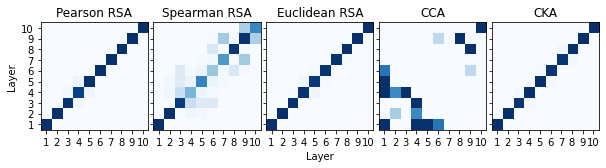

In [12]:
def plot_corr(ax, mat, title, xlabel = False, ylabel = False):
    ax.imshow(np.rot90(mat), cmap = 'Blues')
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.set_xticklabels(np.arange(1, 11, 1))
    ax.set_yticklabels(np.abs(np.arange(1, 11, 1)-11))
    ax.set(adjustable='box', aspect='equal')

    if xlabel:
        ax.set_xlabel('Layer')
    if ylabel:
        ax.set_ylabel('Layer')

# Create 5x1 supblots
fig, axs = plt.subplots(1, 5, figsize = (10, 2), sharey=True)

plot_corr(axs[0], peaRsaConfusion, 'Pearson RSA', ylabel=True)
plot_corr(axs[1], speRsaConfusion, 'Spearman RSA')
plot_corr(axs[2], eucRsaConfusion, 'Euclidean RSA', xlabel=True)
plot_corr(axs[3], ccaConfusion, 'CCA')
plot_corr(axs[4], ckaConfusion, 'CKA')
fig.subplots_adjust(wspace=0.05)
fig.show()

In [13]:
rsaMetrics = ['peaRsa', 'eucRsa', 'speRsa']
sanityPath = '../outputs/masterOutput/sanityCheckSims.csv'
sanityCKA2Path = '../outputs/masterOutput/sanityCheckCKA2.csv'
sanityCCAPath = '../outputs/masterOutput/pwccaSanity.csv'
tmp = pd.read_csv(sanityCKA2Path, index_col=0)
ccaTmp = pd.read_csv(sanityCCAPath, index_col=0)
sanityData = pd.read_csv(sanityPath, index_col=0)
sanityData['cca'] = ccaTmp['pwcca']
sanityData[rsaMetrics] = sanityData[rsaMetrics] ** 2

permutePath = '../outputs/masterOutput/permuteSims.csv'
permuteData = pd.read_csv(permutePath)
permuteCKA2Path = '../outputs/masterOutput/permuteSimsCKA2.csv'
permuteCCAPath = '../outputs/masterOutput/pwccaSimulation.csv'
tmp = pd.read_csv(permuteCKA2Path, index_col=0)
tmp.index = permuteData.index
ccaTmp = pd.read_csv(permuteCCAPath, index_col=0)
ccaTmp.index = permuteData.index
permuteData['cca'] = ccaTmp['pwcca']
permuteData[rsaMetrics] = permuteData[rsaMetrics] ** 2

print(
    f"Sanity Test",
    f"Pearson RSA -- mean {np.mean(sanityData['peaRsa'])}",
    f"SD {np.std(sanityData['peaRsa'])}",
    f"Eucliean RSA -- mean {np.mean(sanityData['eucRsa'])}",
    f"SD {np.std(sanityData['eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(sanityData['speRsa'])}",
    f"SD {np.std(sanityData['speRsa'])}",
    f"CCA -- mean {np.mean(sanityData['cca'])}",
    f"SD {np.std(sanityData['cca'])}",
    f"CKA -- mean {np.mean(sanityData['cka'])}",
    f"SD {np.std(sanityData['cka'])}",
    "",
    f"Random Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'peaRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'eucRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'speRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'cca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'cka'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'random', 'cka'])}",
    '',
    f"Noise Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'peaRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'eucRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'speRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'cca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'cka'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'noise', 'cka'])}",
    '',
    f"Ablation Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'peaRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'eucRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'speRsa'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'cca'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'cka'])}",
    f"SD {np.std(permuteData.loc[permuteData['analysis'] == 'ablate', 'cka'])}",
    '',
    sep = '\n'
)

Sanity Test
Pearson RSA -- mean 1.0000000066757264
SD 1.561989285175216e-07
Eucliean RSA -- mean 1.0000000249147458
SD 1.2923733486810242e-07
Spearman RSA -- mean 1.000000014066702
SD 1.5387125958886842e-07
CCA -- mean 0.9999999998902607
SD 4.420595945139059e-12
CKA -- mean 0.999999999982568
SD 3.374749803477507e-09

Random Test
Pearson RSA -- mean 2.0170857088746415e-06
SD 2.798076121338495e-06
Euclidean RSA -- mean 0.0006344909355506482
SD 0.0009776208241462179
Spearman RSA -- mean 1.985610580715944e-06
SD 2.7588345868243105e-06
CCA -- mean 0.10929730482471547
SD 0.00810473032003974
CKA -- mean 0.009877646119726018
SD 0.0014162291981412115

Noise Test
Pearson RSA -- mean 0.16686611609454063
SD 0.006896493051505981
Euclidean RSA -- mean 0.4226899756010392
SD 0.015760670474015866
Spearman RSA -- mean 0.09437448444008804
SD 0.005065471803846855
CCA -- mean 0.7241175779226278
SD 0.004573400690967582
CKA -- mean 0.5061247735184521
SD 0.006358352685444891

Ablation Test
Pearson RSA -- mean

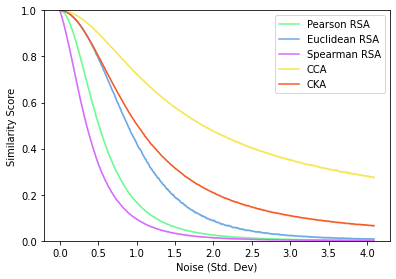

In [14]:
noisePath = '../outputs/masterOutput/noiseSims2021.csv'
ccaPath = '../outputs/masterOutput/pwccaNoise.csv'
noiseData = pd.read_csv(noisePath, index_col=0)
tmp = pd.read_csv(ccaPath, index_col=0)
tmp.index = noiseData.index
noiseData['cca'] = tmp['pwcca']
noiseData[rsaMetrics] = noiseData[rsaMetrics] ** 2

noiseMean = noiseData.groupby(['Noise'])[funNames].agg(np.mean)
noiseCI = noiseData.groupby(['Noise'])[funNames].agg(bootstrapCI)
noiseData.head()

# Get unique noise
noise = noiseData['Noise'].unique()
# Sort noise
noise = np.sort(noise)

fig = plt.figure()
ax = fig.add_axes([0.11, 0.11, .8, .8])
ax.plot(noiseMean['peaRsa'], color=peaRsaColor, label='Pearson RSA')
ax.fill_between(noise, 
    [x[0] for x in noiseCI['peaRsa']], 
    [x[1] for x in noiseCI['peaRsa']], 
    zorder=-1, alpha=0.3, color=peaRsaColor
)
ax.plot(noiseMean['eucRsa'], color=eucRsaColor, label='Euclidean RSA')
ax.fill_between(noise, 
    [x[0] for x in noiseCI['eucRsa']], 
    [x[1] for x in noiseCI['eucRsa']], 
    zorder=-1, alpha=0.3, color=eucRsaColor
)
ax.plot(noiseMean['speRsa'], color=speRsaColor, label='Spearman RSA')
ax.fill_between(noise, 
    [x[0] for x in noiseCI['speRsa']], 
    [x[1] for x in noiseCI['speRsa']], 
    zorder=-1, alpha=0.3, color=speRsaColor
)
ax.plot(noiseMean['cca'], color=ccaColor, label='CCA')
ax.fill_between(noise, 
    [x[0] for x in noiseCI['cca']], 
    [x[1] for x in noiseCI['cca']], 
    zorder=-1, alpha=0.3, color=ccaColor
)
ax.plot(noiseMean['cka'], color=ckaColor, label='CKA')
ax.fill_between(noise, 
    [x[0] for x in noiseCI['cka']], 
    [x[1] for x in noiseCI['cka']], 
    zorder=-1, alpha=0.3, color=ckaColor
)
ax.legend()
ax.set_xlabel('Noise (Std. Dev)')
ax.set_ylabel('Similarity Score')
ax.set_ylim((0, 1))

# Save image
fig.savefig('../visualization/noiseSims.svg', dpi=300)
fig.show()

In [15]:
print(f"CCA mean = {noiseData.loc[noiseData['Noise'] == 4.0, 'cca'].mean()}")
print(f"CCA CI = {bootstrapCI(noiseData.loc[noiseData['Noise'] == 4.0, 'cca'])}")

print(f"CKA mean = {noiseData.loc[noiseData['Noise'] == 4.0, 'cka'].mean()}")
print(f"CKA CI = {bootstrapCI(noiseData.loc[noiseData['Noise'] == 4.0, 'cka'])}")

CCA mean = 0.2823547141386404
CCA CI = (0.2806444055131354, 0.284177956367793)
CKA mean = 0.06842089975946082
CKA CI = (0.06747508833673793, 0.069413083988669)


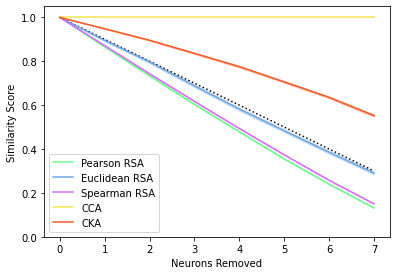

In [16]:
ablatePath = '../outputs/masterOutput/ablateSims.csv'
pwccaPath = '../outputs/masterOutput/pwccaAblate.csv'
ablateData = pd.read_csv(ablatePath, index_col=0)
ablateData['Neurons'] = np.abs(ablateData['Neurons'] - 10)
tmp = pd.read_csv(pwccaPath, index_col=0)
tmp['Neurons'] = np.abs(tmp['Neurons'] - 10)
tmp.index = ablateData.index
ablateData['cca'] = tmp['pwcca']

ablateData[rsaMetrics] = ablateData[rsaMetrics] ** 2
ablateMean = ablateData.groupby(['Neurons'])[funNames].agg(np.mean)
ablateCI = ablateData.groupby(['Neurons'])[funNames].agg(bootstrapCI)

fig = plt.figure()
ax = fig.add_axes([0.11, 0.11, .8, .8])
ax.plot([0,7], [1, .3], 'k:')
ax.plot(ablateMean['peaRsa'], color=peaRsaColor, label='Pearson RSA')
ax.fill_between(range(0, 8), 
    [x[0] for x in ablateCI['peaRsa']], 
    [x[1] for x in ablateCI['peaRsa']], 
    zorder=-1, alpha=0.3, color=peaRsaColor
)
ax.plot(ablateMean['eucRsa'], color=eucRsaColor, label='Euclidean RSA')
ax.fill_between(range(0, 8), 
    [x[0] for x in ablateCI['eucRsa']], 
    [x[1] for x in ablateCI['eucRsa']], 
    zorder=-1, alpha=0.3, color=eucRsaColor
)
ax.plot(ablateMean['speRsa'], color=speRsaColor, label='Spearman RSA')
ax.fill_between(range(0, 8), 
    [x[0] for x in ablateCI['speRsa']], 
    [x[1] for x in ablateCI['speRsa']], 
    zorder=-1, alpha=0.3, color=speRsaColor
)
ax.plot(ablateMean['cca'], color=ccaColor, label='CCA')
ax.fill_between(range(0, 8), 
    [x[0] for x in ablateCI['cca']], 
    [x[1] for x in ablateCI['cca']], 
    zorder=-1, alpha=0.3, color=ccaColor
)
ax.plot(ablateMean['cka'], color=ckaColor, label='CKA')
ax.fill_between(range(0, 8), 
    [x[0] for x in ablateCI['cka']], 
    [x[1] for x in ablateCI['cka']], 
    zorder=-1, alpha=0.3, color=ckaColor
)

ax.legend()
ax.set_xlabel('Neurons Removed')
ax.set_ylabel('Similarity Score')
ax.set_ylim(0, 1.05)
fig.show()

/tmp/ipykernel_2796124/672799905.py:3: RuntimeWarning: Mean of empty slice
  [np.nanmean(np.random.choice(x, len(x))) for i in range(nSamples)]


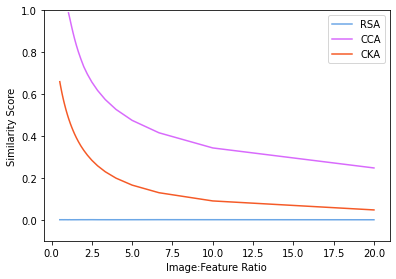

In [17]:
ratioPath = '../outputs/masterOutput/ratioSims.csv'
pwccaPath = '../outputs/masterOutput/pwccaSizeRatio.csv'
ratioSims = pd.read_csv(ratioPath)
tmp = pd.read_csv(pwccaPath)
tmp.index = ratioSims.index
ratioSims['cca'] = tmp['pwcca']
ratioSims[rsaMetrics] = ratioSims[rsaMetrics] ** 2
ratioSims['ratio'] = ratioSims['sample'] / ratioSims['features']

ratios = ratioSims['ratio'].unique()
ratioData = pd.DataFrame(columns=list(ratioSims.columns[0:3]) + ['ratio'], index=range(len(ratios)))
for i, ratio in enumerate(ratios):
    ratioData.loc[i] = list(ratioSims.loc[ratioSims['ratio'] == ratio, ratioSims.columns[0:3]].mean('index')) + [ratio]

ratioMeans = ratioSims.groupby(['ratio'])[funNames].agg(np.mean)
ratioCI = ratioSims.groupby(['ratio'])[funNames].agg(bootstrapCI)

fig = plt.figure()
ax = fig.add_axes([0.11, 0.11, .8, .8])
ax.plot(ratioMeans['eucRsa'], label='RSA', color=eucRsaColor)
ax.plot(ratioMeans['cca'], label='CCA', color=speRsaColor)
ax.plot(ratioMeans['cka'], label='CKA', color=ckaColor)
ax.set_xlabel('Image:Feature Ratio')
ax.set_ylabel('Similarity Score')
ax.legend()

ax.set_ylim(-.1, 1)
fig.show()

In [18]:
print(f"CKA at 20:1 ratio: {ratioSims.loc[ratioSims['ratio'] == 20.0, 'cka'].mean()}")

CKA at 20:1 ratio: 0.04739673167044809


In [19]:
trainingTraj_seed = pd.read_csv('../outputs/masterOutput/trainingTraj.csv')
finalAcc_seed = trainingTraj_seed['valAcc'].loc[trainingTraj_seed['epoch'] == 349]
print('Accuracy Mean - Seed: '+str(np.mean(finalAcc_seed)))
print('Accuracy 95CI - Seed: '+str(bootstrapCI(finalAcc_seed)))
print(f'Accuracy Range - Seed: {np.min(finalAcc_seed)} - {np.max(finalAcc_seed)}')
print()
trainingMean_seed = trainingTraj_seed.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_seed = trainingTraj_seed.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_item_max3 = pd.read_csv('../outputs/masterOutput/trainingTraj_itemDiff_max3.csv')
finalAcc_item_max3 = trainingTraj_item_max3['valAcc'].loc[trainingTraj_item_max3['epoch'] == 349]
print('Accuracy Mean - item max 3: '+str(np.mean(finalAcc_item_max3)))
print('Accuracy 95CI - item max 3: '+str(bootstrapCI(finalAcc_item_max3)))
print(f'Accuracy Range - item max 3: {np.min(finalAcc_item_max3)} - {np.max(finalAcc_item_max3)}')
print()

trainingMean_item_max3 = trainingTraj_item_max3.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_item_max3 = trainingTraj_item_max3.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_item_max10 = pd.read_csv('../outputs/masterOutput/trainingTraj_itemDiff_max10.csv')
finalAcc_item_max10 = trainingTraj_item_max10['valAcc'].loc[trainingTraj_item_max10['epoch'] == 349]
print('Accuracy Mean - item max 10: '+str(np.mean(finalAcc_item_max10)))
print('Accuracy 95CI - item max 10: '+str(bootstrapCI(finalAcc_item_max10)))
print(f'Accuracy Range - item max 10: {np.min(finalAcc_item_max10)} - {np.max(finalAcc_item_max10)}')
print()

trainingMean_item_max10 = trainingTraj_item_max10.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_item_max10 = trainingTraj_item_max10.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_item_max100 = pd.read_csv('../outputs/masterOutput/trainingTraj_itemDiff_max100.csv')
finalAcc_item_max100 = trainingTraj_item_max100['valAcc'].loc[trainingTraj_item_max100['epoch'] == 349]
print('Accuracy Mean - item max 100: '+str(np.mean(finalAcc_item_max100)))
print('Accuracy 95CI - item max 100: '+str(bootstrapCI(finalAcc_item_max100)))
print(f'Accuracy Range - item max 100: {np.min(finalAcc_item_max100)} - {np.max(finalAcc_item_max100)}')
print()

trainingMean_item_max100 = trainingTraj_item_max100.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_item_max100 = trainingTraj_item_max100.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_cat_max3 = pd.read_csv('../outputs/masterOutput/trainingTraj_catDiff_max1-3.csv')
finalAcc_cat_max3 = trainingTraj_cat_max3['valAcc'].loc[trainingTraj_cat_max3['epoch'] == 349]
print('Accuracy Mean - cat max 3: '+str(np.mean(finalAcc_cat_max3)))
print('Accuracy 95CI - cat max 3: '+str(bootstrapCI(finalAcc_cat_max3)))
print(f'Accuracy Range - cat max 3: {np.min(finalAcc_cat_max3)} - {np.max(finalAcc_cat_max3)}')
print()

trainingMean_cat_max3 = trainingTraj_cat_max3.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_cat_max3 = trainingTraj_cat_max3.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_cat_max10 = pd.read_csv('../outputs/masterOutput/trainingTraj_catDiff_max1-10.csv')
finalAcc_cat_max10 = trainingTraj_cat_max10['valAcc'].loc[trainingTraj_cat_max10['epoch'] == 349]
print('Accuracy Mean - cat max 10: '+str(np.mean(finalAcc_cat_max10)))
print('Accuracy 95CI - cat max 10: '+str(bootstrapCI(finalAcc_cat_max10)))
print(f'Accuracy Range - cat max 10: {np.min(finalAcc_cat_max10)} - {np.max(finalAcc_cat_max10)}')
print()

trainingMean_cat_max10 = trainingTraj_cat_max10.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_cat_max10 = trainingTraj_cat_max10.groupby('epoch')['valAcc'].agg(bootstrapCI)

trainingTraj_cat_max100 = pd.read_csv('../outputs/masterOutput/trainingTraj_catDiff_max1-100.csv')
finalAcc_cat_max100 = trainingTraj_cat_max100['valAcc'].loc[trainingTraj_cat_max100['epoch'] == 349]
print('Accuracy Mean - cat max 100: '+str(np.mean(finalAcc_cat_max100)))
print('Accuracy 95CI - cat max 100: '+str(bootstrapCI(finalAcc_cat_max100)))
print(f'Accuracy Range - cat max 100: {np.min(finalAcc_cat_max100)} - {np.max(finalAcc_cat_max100)}')
print()

trainingMean_cat_max100 = trainingTraj_cat_max100.groupby('epoch')['valAcc'].agg(np.mean)
trainingCI_cat_max100 = trainingTraj_cat_max100.groupby('epoch')['valAcc'].agg(bootstrapCI)

Accuracy Mean - Seed: 0.908897
Accuracy 95CI - Seed: (0.9084129999999999, 0.909317)
Accuracy Range - Seed: 0.9011 - 0.9143

Accuracy Mean - item max 3: 0.88193
Accuracy 95CI - item max 3: (0.8806800000000001, 0.88307)
Accuracy Range - item max 3: 0.878 - 0.8837

Accuracy Mean - item max 10: 0.87995
Accuracy 95CI - item max 10: (0.8789999999999999, 0.8808499999999999)
Accuracy Range - item max 10: 0.8771 - 0.8825

Accuracy Mean - item max 100: 0.879282
Accuracy 95CI - item max 100: (0.8784879999999999, 0.880068)
Accuracy Range - item max 100: 0.8732 - 0.8851

Accuracy Mean - cat max 3: 0.8777839999999999
Accuracy 95CI - cat max 3: (0.876808, 0.878768)
Accuracy Range - cat max 3: 0.8692 - 0.8857

Accuracy Mean - cat max 10: 0.8666620000000002
Accuracy 95CI - cat max 10: (0.8636760000000001, 0.869416)
Accuracy Range - cat max 10: 0.8451 - 0.8865

Accuracy Mean - cat max 100: 0.8535260000000001
Accuracy 95CI - cat max 100: (0.848166, 0.8585599999999998)
Accuracy Range - cat max 100: 0.8059

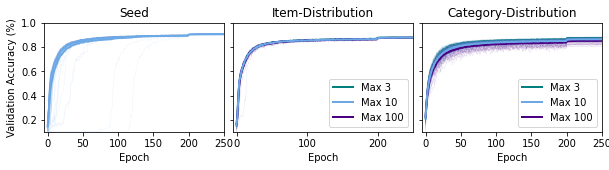

In [20]:
def plotTraj(
    ax, 
    trainingMean, 
    trainingTraj, 
    color='k', 
    label='', 
    title='', 
    xlabel='', 
    ylabel='', 
    legend=False, 
    zorder=0):
    # Plot mean and CI
    ax.plot(range(len(trainingMean)), trainingMean, color=color, zorder=zorder, linewidth=2, label=label)

    # Get unique logs
    logs = trainingTraj['log'].unique()
    # Loop through logs and plot validation accuracy
    for i, log in enumerate(logs):
        logAcc = trainingTraj.loc[trainingTraj['log'] == log, 'valAcc']
        ax.plot(range(len(logAcc)), logAcc, color=color, alpha=0.2, zorder=zorder-1, linewidth=0.25)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((-5, 250))
    ax.set_ylim((.1, 1))

    if legend:
        ax.legend()

fig, axs = plt.subplots(1, 3, figsize = (10, 2), sharey=True)

plotTraj(
    ax=axs[0], 
    trainingMean=trainingMean_seed, 
    trainingTraj=trainingTraj_seed, 
    color=eucRsaColor, 
    label='Seed', 
    xlabel='Epoch', 
    ylabel='Validation Accuracy (%)', 
    zorder=2, 
    legend=False,
    title="Seed")


plotTraj(
    ax=axs[1], 
    trainingMean=trainingMean_item_max3, 
    trainingTraj=trainingTraj_item_max3, 
    color='teal', 
    label='Max 3', 
    xlabel='Epoch', 
    ylabel='', 
    zorder=1)
plotTraj(
    ax=axs[1], 
    trainingMean=trainingMean_item_max10, 
    trainingTraj=trainingTraj_item_max10, 
    color=eucRsaColor, 
    label='Max 10', 
    xlabel='Epoch', 
    ylabel='', 
    zorder=3)
plotTraj(
    ax=axs[1], 
    trainingMean=trainingMean_item_max100, 
    trainingTraj=trainingTraj_item_max100, 
    color='indigo', 
    label='Max 100', 
    xlabel='Epoch', 
    ylabel='', 
    zorder=2,
    title='Item-Distribution',
    legend=True)


plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max3,
    trainingTraj=trainingTraj_cat_max3,
    color='teal',
    label='Max 3',
    xlabel='Epoch',
    ylabel='',
    zorder=1)
plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max10,
    trainingTraj=trainingTraj_cat_max10,
    color=eucRsaColor,
    label='Max 10',
    xlabel='Epoch',
    ylabel='',
    zorder=3)
plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max100,
    trainingTraj=trainingTraj_cat_max100,
    color='indigo',
    label='Max 100',
    xlabel='Epoch',
    ylabel='',
    zorder=2,
    title='Category-Distribution',
    legend=True)

fig.subplots_adjust(wspace=0.05)
fig.show()

In [21]:
seedDiffSims = pd.read_csv('../outputs/masterOutput/similarities/seedDiff_allLayers.csv')
seedDiffSims.eucRsa = seedDiffSims.eucRsa ** 2

weight1 = np.zeros_like(seedDiffSims.eucRsa)
weight2 = np.zeros_like(seedDiffSims.eucRsa)
shuffle1 = np.zeros_like(seedDiffSims.eucRsa)
shuffle2 = np.zeros_like(seedDiffSims.eucRsa)
for row in seedDiffSims.iterrows():
    weight, shuffle = row[1].model1.split('s')
    weight1[row[0]] = int(weight[1])
    shuffle1[row[0]] = int(shuffle)

    weight, shuffle = row[1].model2.split('s')
    weight2[row[0]] = int(weight[1])
    shuffle2[row[0]] = int(shuffle)

seedDiffSims['weight1'] = weight1.astype(int)
seedDiffSims['weight2'] = weight2.astype(int)
seedDiffSims['shuffle1'] = shuffle1.astype(int)
seedDiffSims['shuffle2'] = shuffle2.astype(int)

seedDiffSims.head()

,model1,model2,eucRsa,cka,layer,weight1,weight2,shuffle1,shuffle2
0,w1s0,w0s0,0.842940,0.872618,5,1,0,0,0
1,w2s0,w0s0,0.930062,0.926449,5,2,0,0,0
2,w2s0,w1s0,0.837260,0.876816,5,2,1,0,0
3,w3s0,w0s0,0.900026,0.913239,5,3,0,0,0
4,w3s0,w1s0,0.821347,0.878421,5,3,1,0,0


In [22]:
# Loop through weight/shuffle seeds and layers
weights = seedDiffSims.weight1.unique()
weights.sort()
shuffles = seedDiffSims.shuffle1.unique()
shuffles.sort()
layers = seedDiffSims.layer.unique()
layers.sort()
shuffleDiffs = np.zeros((len(weights), math.comb(len(shuffles), 2), len(layers)))
weightDiffs = np.zeros((len(weights), math.comb(len(weights), 2), len(layers)))
for weightSeed in weights:
    # Find rows with matching weight seeds for both models
    weightRows = seedDiffSims.loc[(seedDiffSims['weight1'] == weightSeed) & (seedDiffSims['weight2'] == weightSeed)]

    for layer in layers:
        layerRows = weightRows.loc[weightRows['layer'] == layer]
        layerRows = layerRows.sort_values(['shuffle1', 'shuffle2'])

        # Save eucRsa scores
        shuffleDiffs[weightSeed, :, layer] = layerRows.eucRsa.values

for shuffleSeed in shuffles:
    # Find rows with matching weight seeds for both models
    shuffleRows = seedDiffSims.loc[(seedDiffSims['shuffle1'] == shuffleSeed) & (seedDiffSims['shuffle2'] == shuffleSeed)]

    for layer in layers:
        layerRows = shuffleRows.loc[shuffleRows['layer'] == layer]
        layerRows = layerRows.sort_values(['weight1', 'weight2'])

        # Save eucRsa scores
        weightDiffs[shuffleSeed, :, layer] = layerRows.eucRsa.values

# Print average eucRsa scores
print('Average eucRsa scores for weight seeds:')
print(np.mean(shuffleDiffs, axis=(0, 1)))
print('Average eucRsa scores for shuffle seeds:')
print(np.mean(weightDiffs, axis=(0, 1)))

Average eucRsa scores for weight seeds:
[0.99945123 0.99149213 0.98384934 0.96983476 0.94919271 0.91365421
 0.84700686 0.83780274 0.83105896 0.8630067  0.77223915]
Average eucRsa scores for shuffle seeds:
[0.99862459 0.98822782 0.97980689 0.96458474 0.94119645 0.90453419
 0.83728612 0.82926539 0.82064871 0.85565349 0.76494297]


In [25]:
layers

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

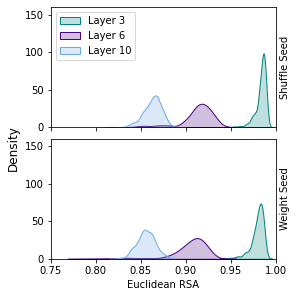

In [27]:
colors = ['teal', 'indigo', eucRsaColor]
layers = [2, 5, 9]
xLims = (.75, 1)
yLims = (0, 160)
layerShuffleDiffs = np.mean(shuffleDiffs, axis=(0, 1))
layerWeightDiffs = np.mean(weightDiffs, axis=(0, 1))

fig, ax = plt.subplots(2, 1, figsize=(4, 4), constrained_layout=True, sharex=True, sharey=True)
for i, layer in enumerate(layers):
    sns.kdeplot(shuffleDiffs[:, :, layer].flatten(), ax=ax[0], shade=True, color=colors[i], label=f'Layer {layer+1}')
    sns.kdeplot(weightDiffs[:, :, layer].flatten(), ax=ax[1], shade=True, color=colors[i], label=f'Layer {layer+1}')

# Show legend on left side
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='upper left')


ax[1].set_xlim(*xLims)
ax[1].set_ylim(*yLims)

ax[0].set_ylabel('Shuffle Seed')
ax[0].yaxis.set_label_position("right")
ax[1].set_ylabel('Weight Seed')
ax[1].yaxis.set_label_position("right")

ax[1].set_xlabel('Euclidean RSA')

fig.supylabel('Density')
fig.show()

In [28]:
# Get average eucRsa scores by layer
maxVals = [3, 10, 100]
diffType = ['item', 'cat']

itemCatDiffs = pd.DataFrame()
for layer in layers:
    for maxi in maxVals:
        tmp = pd.read_csv(f'../outputs/masterOutput/similarities/itemDiff_max{maxi}_layer{layer}.csv', index_col=0)

        # Add layer, max, and type of difference to df
        tmp['layer'] = layer
        tmp['max'] = maxi
        tmp['type'] = 'item'

        # Append to df
        itemCatDiffs = itemCatDiffs.append(tmp)

        tmp = pd.read_csv(f'../outputs/masterOutput/similarities/catDiff_max1-{maxi}_layer{layer}.csv', index_col=0)

        # Add layer, max, and type of difference to df
        tmp['layer'] = layer
        tmp['max'] = maxi
        tmp['type'] = 'cat'

        # Append to df
        itemCatDiffs = itemCatDiffs.append(tmp)

# Remove the cka column
itemCatDiffs = itemCatDiffs.drop(columns=['cka'])

itemCatDiffs.head()

# Get average eucRsa scores by layer and max and type
print('Average eucRsa scores by layer, max, and type:')
for diff in diffType:
    for maxi in maxVals:
        for layer in layers:
            tmp = itemCatDiffs.loc[(itemCatDiffs['layer'] == layer) & (itemCatDiffs['max'] == maxi) & (itemCatDiffs['type'] == diff)]
            print(f'Layer: {layer+1}, Max: {maxi}, Type: {diff}, eucRsa: {np.mean(tmp.eucRsa)}')

    print()

Average eucRsa scores by layer, max, and type:
Layer: 3, Max: 3, Type: item, eucRsa: 0.9882565133425654
Layer: 6, Max: 3, Type: item, eucRsa: 0.947359888018394
Layer: 10, Max: 3, Type: item, eucRsa: 0.8912783752545819
Layer: 3, Max: 10, Type: item, eucRsa: 0.987854347520945
Layer: 6, Max: 10, Type: item, eucRsa: 0.9482648179969009
Layer: 10, Max: 10, Type: item, eucRsa: 0.8963187735907886
Layer: 3, Max: 100, Type: item, eucRsa: 0.9869909001856434
Layer: 6, Max: 100, Type: item, eucRsa: 0.9445315475853122
Layer: 10, Max: 100, Type: item, eucRsa: 0.885998755286282

Layer: 3, Max: 3, Type: cat, eucRsa: 0.9854187181044598
Layer: 6, Max: 3, Type: cat, eucRsa: 0.9386801139675841
Layer: 10, Max: 3, Type: cat, eucRsa: 0.8812286331992186
Layer: 3, Max: 10, Type: cat, eucRsa: 0.9832318211088376
Layer: 6, Max: 10, Type: cat, eucRsa: 0.9324531405799243
Layer: 10, Max: 10, Type: cat, eucRsa: 0.8784371791567122
Layer: 3, Max: 100, Type: cat, eucRsa: 0.9805461223271428
Layer: 6, Max: 100, Type: cat, 

In [29]:
layer10max3 = itemCatDiffs[(
    (itemCatDiffs['layer'] == 9) & 
    (itemCatDiffs['max'] == 3) & 
    (itemCatDiffs['type'] == 'cat')
)].eucRsa
layer10max100 = itemCatDiffs[(
    (itemCatDiffs['layer'] == 9) & 
    (itemCatDiffs['max'] == 100) & 
    (itemCatDiffs['type'] == 'cat')
)].eucRsa

print(f"CI of eucRsa scores for layer 10, max 10: {np.min(layer10max3)} - {np.max(layer10max3)}")
print(f"CI of eucRsa scores for layer 10, max 100: {np.min(layer10max100)} - {np.max(layer10max100)}")

CI of eucRsa scores for layer 10, max 10: 0.8540406682111097 - 0.9068846068151208
CI of eucRsa scores for layer 10, max 100: 0.7765984028960705 - 0.904244201501008


Text(0.02, 0.5, 'Density')

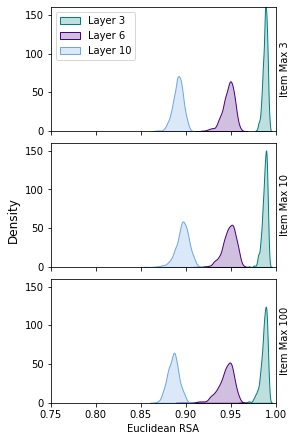

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), constrained_layout=True, sharex=True, sharey=True)

for i, maxi in enumerate(maxVals):
    ax[i].set_ylabel(f'Item Max {maxi}')
    ax[i].yaxis.set_label_position("right")
    for j, layer in enumerate(layers):
        tmpBool = (
            (itemCatDiffs['layer'] == layer) & 
            (itemCatDiffs['max'] == maxi) & 
            (itemCatDiffs['type'] == 'item')
        )
        tmp = itemCatDiffs.loc[tmpBool]
        sns.kdeplot(
            tmp.eucRsa, 
            ax=ax[i], 
            shade=True, 
            color=colors[j], 
            label=f'Layer {layer+1}')

# Show legend on left side
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='upper left')

ax[2].set_xlabel('Euclidean RSA')
ax[2].set_xlim(*xLims)
ax[2].set_ylim(*yLims)

fig.supylabel('Density')

Text(0.02, 0.5, 'Density')

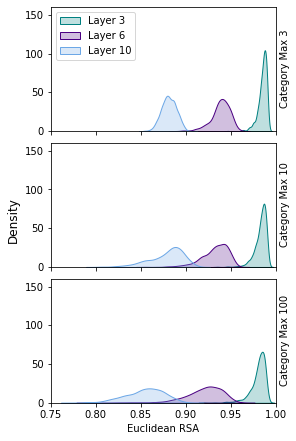

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), constrained_layout=True, sharex=True, sharey=True)

for i, maxi in enumerate(maxVals):
    ax[i].set_ylabel(f'Category Max {maxi}')
    ax[i].yaxis.set_label_position("right")
    for j, layer in enumerate(layers):
        tmpBool = (
            (itemCatDiffs['layer'] == layer) & 
            (itemCatDiffs['max'] == maxi) & 
            (itemCatDiffs['type'] == 'cat')
        )
        tmp = itemCatDiffs.loc[tmpBool]
        sns.kdeplot(
            tmp.eucRsa, 
            ax=ax[i], 
            shade=True, 
            color=colors[j], 
            label=f'Layer {layer+1}')

# Show legend on left side
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='upper left')

ax[2].set_xlabel('Euclidean RSA')
ax[2].set_xlim(*xLims)
ax[2].set_ylim(*yLims)

fig.supylabel('Density')

In [49]:
layerMapping = {
    0: -1,
    1: 0,
    2: 1,
    3: 2,
    4: -1,
    5: 3,
    6: 4,
    7: 5,
    8: -1,
    9: 6,
    10: 7,
    11: 8,
    12: -1,
    13: -1,
}
diffTypes = ['seedDiff', 'itemDiff', 'catDiff']

# Load baseline 
baseline = pd.read_csv('../outputs/masterOutput/baseline/compiled/maxAug-seedDiff.csv', index_col=0)
baseline['type'] = 'seedDiff'

# Load item diffs and combine
tmp = pd.read_csv('../outputs/masterOutput/baseline/compiled/maxAug-itemDiff_max10.csv', index_col=0)
tmp['type'] = 'itemDiff'
baseline = baseline.append(tmp)

# Load cat diffs and combine
tmp = pd.read_csv('../outputs/masterOutput/baseline/compiled/maxAug-catDiff_max1-10.csv', index_col=0)
tmp['type'] = 'catDiff'
baseline = baseline.append(tmp)

baseline = baseline.loc[baseline.layer.apply(lambda x: not layerMapping[x] == -1)]
baseline['layer'] = baseline['layer'].apply(lambda x: layerMapping[x])
baseline.eucRsa = baseline.eucRsa ** 2

# Get layers
layers = baseline.layer.unique()

# Calculate means and CI by type and layer
baselineTypeMeans = baseline.groupby(['type', 'layer'])['eucRsa'].mean()
baselineTypeLowerCI = baseline.groupby(['type', 'layer'])['eucRsa'].apply(lambda x: bootstrapCI(x)[0])
baselineTypeUpperCI = baseline.groupby(['type', 'layer'])['eucRsa'].apply(lambda x: bootstrapCI(x)[1])

# Overall type mean
baselineMeans = baseline.groupby('layer')['eucRsa'].mean()
baselineLowerCI = baseline.groupby('layer')['eucRsa'].apply(lambda x: bootstrapCI(x)[0])
baselineUpperCI = baseline.groupby('layer')['eucRsa'].apply(lambda x: bootstrapCI(x)[1])

# Average eucRsa scores by type then layer
baselineTypeMeans

type      layer
catDiff   0        0.931432
          1        0.901830
          2        0.877721
          3        0.855987
          4        0.837262
          5        0.788032
          6        0.730113
          7        0.752266
          8        0.741733
itemDiff  0        0.931446
          1        0.902145
          2        0.876629
          3        0.856667
          4        0.843516
          5        0.799042
          6        0.736400
          7        0.746031
          8        0.734485
seedDiff  0        0.929401
          1        0.903891
          2        0.884903
          3        0.863048
          4        0.836276
          5        0.775460
          6        0.709366
          7        0.751225
          8        0.750888
Name: eucRsa, dtype: float64

In [50]:
baselineMeans

layer
0    0.930420
1    0.902930
2    0.881000
3    0.859654
4    0.838375
5    0.784683
6    0.721555
7    0.750165
8    0.744368
Name: eucRsa, dtype: float64

In [33]:
seedDiffSims = pd.read_csv('../outputs/masterOutput/similarities/seedDiff_allLayers.csv')
seedDiffSims.eucRsa = seedDiffSims.eucRsa ** 2

# Only keep layers 8 and below
seedDiffSims = seedDiffSims.loc[seedDiffSims['layer'] <= 8]

# Calculate means and CIs
eucRsaSeedMeans = seedDiffSims.groupby('layer')['eucRsa'].agg(np.mean)
eucRsaSeedLowerCIs = seedDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[0])
eucRsaSeedUpperCIs = seedDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[1])

# Print means and CIs at each layer
print('Seed Diff average eucRsa scores by layer:')
for layer in layers:
    print(f'Layer: {layer+1}, eucRsa: {eucRsaSeedMeans[layer]}')
    print(f'Layer: {layer+1}, eucRsa CI: {eucRsaSeedLowerCIs[layer]} - {eucRsaSeedUpperCIs[layer]}')

Seed Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9986989500775735
Layer: 1, eucRsa CI: 0.9986836774068908 - 0.9987154992691345
Layer: 2, eucRsa: 0.9885786744927535
Layer: 2, eucRsa CI: 0.9884544464302598 - 0.9887017824946933
Layer: 3, eucRsa: 0.9802678831644992
Layer: 3, eucRsa CI: 0.9800902138575724 - 0.980449028489253
Layer: 4, eucRsa: 0.965115746162765
Layer: 4, eucRsa CI: 0.9648075185088734 - 0.9653776588852608
Layer: 5, eucRsa: 0.9420786705284777
Layer: 5, eucRsa CI: 0.9416179571265795 - 0.9425576856738549
Layer: 6, eucRsa: 0.9054183472171837
Layer: 6, eucRsa CI: 0.9048538954353463 - 0.9060058548526251
Layer: 7, eucRsa: 0.8371676468440312
Layer: 7, eucRsa CI: 0.8363653755385314 - 0.837934127231776
Layer: 8, eucRsa: 0.8294101235533033
Layer: 8, eucRsa CI: 0.828993436393088 - 0.8298606742655308
Layer: 9, eucRsa: 0.8211353970668771
Layer: 9, eucRsa CI: 0.8206336296009781 - 0.8216318632584015


In [34]:
itemDiffSims = pd.read_csv('../outputs/masterOutput/similarities/itemDiff_max10_allLayers.csv')
itemDiffSims.eucRsa = itemDiffSims.eucRsa ** 2

# Only keep layers 8 and below
itemDiffSims = itemDiffSims.loc[itemDiffSims['layer'] <= 8]

# Calculate means and CIs
eucRsaItemMeans = itemDiffSims.groupby('layer')['eucRsa'].agg(np.mean)
eucRsaItemLowerCIs = itemDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[0])
eucRsaItemUpperCIs = itemDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[1])

# Print means and CIs at each layer
print('Item Diff average eucRsa scores by layer:')
for layer in layers:
    print(f'Layer: {layer+1}, eucRsa: {eucRsaItemMeans[layer]}')
    print(f'Layer: {layer+1}, eucRsa CI: {eucRsaItemLowerCIs[layer]} - {eucRsaItemUpperCIs[layer]}')

Item Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9995396295645106
Layer: 1, eucRsa CI: 0.9994756857568934 - 0.9995940992793159
Layer: 2, eucRsa: 0.9880502071492645
Layer: 2, eucRsa CI: 0.9865148409663643 - 0.9894308483760982
Layer: 3, eucRsa: 0.9760125131516035
Layer: 3, eucRsa CI: 0.9730942957018105 - 0.9786758067475887
Layer: 4, eucRsa: 0.9546087183217773
Layer: 4, eucRsa CI: 0.9493134164114492 - 0.9595810969836471
Layer: 5, eucRsa: 0.9258445641481149
Layer: 5, eucRsa CI: 0.9183818628064078 - 0.9333340442568202
Layer: 6, eucRsa: 0.9028557210572787
Layer: 6, eucRsa CI: 0.8976824384601867 - 0.9070796557289089
Layer: 7, eucRsa: 0.8153275380942802
Layer: 7, eucRsa CI: 0.8101551858256542 - 0.82043078246961
Layer: 8, eucRsa: 0.7827152040786037
Layer: 8, eucRsa CI: 0.7772143192515021 - 0.788425484727448
Layer: 9, eucRsa: 0.7890689501445362
Layer: 9, eucRsa CI: 0.7831237857414741 - 0.7950600450078932


In [35]:
catDiffSims = pd.read_csv('../outputs/masterOutput/similarities/catDiff_max1-10_allLayers.csv')
catDiffSims.eucRsa = catDiffSims.eucRsa ** 2

# Only keep layers 8 and below
catDiffSims = catDiffSims.loc[catDiffSims['layer'] <= 8]

# Calculate means and CIs
eucRsaCatMeans = catDiffSims.groupby('layer')['eucRsa'].agg(np.mean)
eucRsaCatLowerCIs = catDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[0])
eucRsaCatUpperCIs = catDiffSims.groupby('layer')['eucRsa'].agg(lambda x: bootstrapCI(x)[1])

# Print means and CIs at each layer
print('Cat Diff average eucRsa scores by layer:')
for layer in layers:
    print(f'Layer: {layer+1}, eucRsa: {eucRsaCatMeans[layer]}')
    print(f'Layer: {layer+1}, eucRsa CI: {eucRsaCatLowerCIs[layer]} - {eucRsaCatUpperCIs[layer]}')

Cat Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9990723045303692
Layer: 1, eucRsa CI: 0.9989314577941448 - 0.9992141310712801
Layer: 2, eucRsa: 0.9847097456454794
Layer: 2, eucRsa CI: 0.9825385393421223 - 0.9867315825861187
Layer: 3, eucRsa: 0.9722516544048716
Layer: 3, eucRsa CI: 0.9689356045964335 - 0.9752768291706554
Layer: 4, eucRsa: 0.9446342799897209
Layer: 4, eucRsa CI: 0.9393342381216547 - 0.9499393585857033
Layer: 5, eucRsa: 0.9108845237389407
Layer: 5, eucRsa CI: 0.9048498542845718 - 0.9170346498719759
Layer: 6, eucRsa: 0.8499570228466482
Layer: 6, eucRsa CI: 0.8431702550849867 - 0.8570342150091769
Layer: 7, eucRsa: 0.7288003176874757
Layer: 7, eucRsa CI: 0.7173886419197665 - 0.7404957540554558
Layer: 8, eucRsa: 0.6597692116315393
Layer: 8, eucRsa CI: 0.6420932834164272 - 0.6776706150556915
Layer: 9, eucRsa: 0.6189423670893633
Layer: 9, eucRsa CI: 0.5943405860736173 - 0.6436365329882484


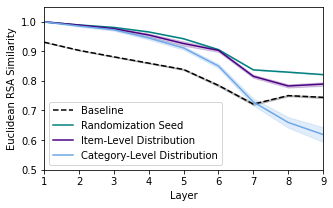

In [51]:
# Plot eucRSA scores by layer
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

plotLayers = layers + 1
# Plot baseline
ax.plot(
    plotLayers,
    baselineMeans,
    color='black',
    label='Baseline',
    linestyle='--'
)
ax.fill_between(
    plotLayers,
    baselineLowerCI,
    baselineUpperCI,
    color='black',
    alpha=0.2
)

# Plot seed diffs
ax.plot(
    plotLayers,
    eucRsaSeedMeans,
    color=colors[0],
    label='Randomization Seed'
)
ax.fill_between(
    plotLayers,
    eucRsaSeedLowerCIs,
    eucRsaSeedUpperCIs,
    color=colors[0],
    alpha=0.2
)

# Plot item diffs
ax.plot(
    plotLayers,
    eucRsaItemMeans,
    color=colors[1],
    label='Item-Level Distribution'
)
ax.fill_between(
    plotLayers,
    eucRsaItemLowerCIs,
    eucRsaItemUpperCIs,
    color=colors[1],
    alpha=0.2
)

# Plot cat diffs
ax.plot(
    plotLayers,
    eucRsaCatMeans,
    color=colors[2],
    label='Category-Level Distribution'
)
ax.fill_between(
    plotLayers,
    eucRsaCatLowerCIs,
    eucRsaCatUpperCIs,
    color=colors[2],
    alpha=0.2
)

# Add legend on bottom right
ax.legend(loc='lower left')

# Add labels
ax.set_xlabel('Layer')
ax.set_ylabel('Euclidean RSA Similarity')

# Set axis limits
ax.set_xlim(1, 9)
ax.set_ylim(.5, 1.05)
fig.show()